In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [2]:
### Шаг 1. Определение функций, которые понадобятся для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return (x)*(1 - (x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

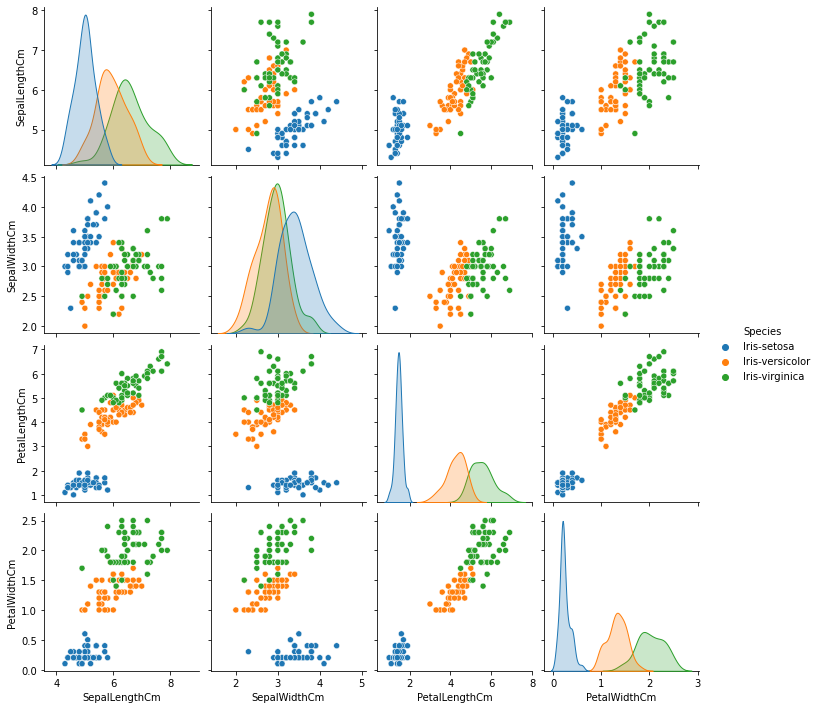

In [3]:
### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("../Manuals/lesson_1/Iris.csv")
# print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)

x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)

y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [4]:
### Шаг 3. Обученние нейронной сети

# определим число нейронов скрытого слоя в именованных атрибутах
def two_layered_neu(neuron_numb=10, n=0.1, iterations=10000): # n-скорость обучения

    # присваевание случайных весов
    w0 = 2*np.random.random((4, neuron_numb)) - 1 # для входного слоя   - 4 входа, 3 выхода
    w1 = 2*np.random.random((neuron_numb, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода

    # массив для ошибок, чтобы потом построить график
    errors = []

    # процесс обучения
    for i in range(iterations):

        # прямое распространение(feed forward)
        layer0 = X_train
        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train - layer2 # производная функции потерь = производная квадратичных потерь 
        layer2_delta = layer2_error * sigmoid_deriv(layer2)

        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)
        # коррекция
        w1 += layer1.T.dot(layer2_delta) * n
        w0 += layer0.T.dot(layer1_delta) * n
        # метрика модели
        error = np.mean(np.abs(layer2_error))
        errors.append(error)
        accuracy = (1 - error) * 100
        
#     print(f'Число нейронов {neuron_numb}, Скорость обучения {n}, Количество итераций {iterations}')
#     print("Аккуратность нейронной сети " + str(round(accuracy,2)) + "%")
    
    return round(accuracy, 2), errors, layer2, w0, w1


### Шаг 4. Демонстрация полученных результатов
# черчение диаграммы точности в зависимости от обучения

def plots(errors, last_layer, y_train, accuracy, neuron_numb=10, n=0.1, iterations=10000):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    ax1.plot(errors)
    ax1.set_xlabel('Обучение')
    ax1.set_ylabel('Ошибка')

    N = 50
    ax2.plot(last_layer[:N,1], 'r',label = 'Y new')
    ax2.plot(y_train[:N,1],'g', label = 'Y train')
    ax2.set_xlabel('№ примера')
    ax2.set_ylabel('выход сети и целевой')
    
    fig.suptitle(f'Число нейронов {neuron_numb}, Скорость обучения {n}, Количество итераций {iterations}, Точность {accuracy}')
    plt.legend()
    plt.show()

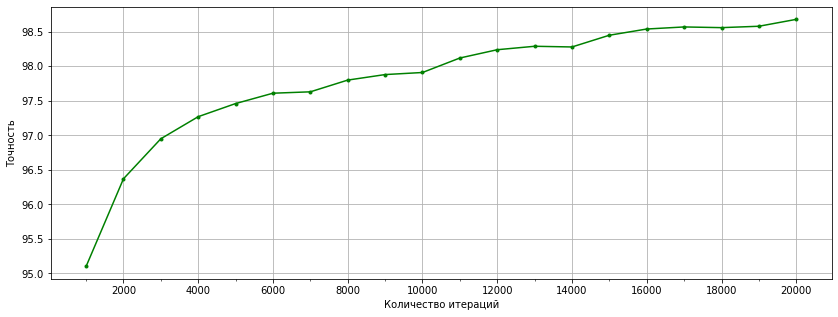

In [5]:
# Для начала попробуем варьировать количество итераций

iter_values = []
range_values = range(1000, 20000 + 1, 1000)
for try_iterations in range_values:
    accuracy, error, last_layer, w0, w1 = two_layered_neu(iterations=try_iterations)
    iter_values.append(accuracy)
    
fig, ax = plt.subplots()
ax.plot(range_values, iter_values, 'g.-')

fig.set_figwidth(14)
fig.set_figheight(5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1000))

plt.xlabel('Количество итераций')
plt.ylabel('Точность')
plt.grid()
plt.show()

#### По графику чётко видно, что увеличение количества итераций добавляет точность нейронной сети. Причем после количества итераций 8000 точность растет намного медленнее.

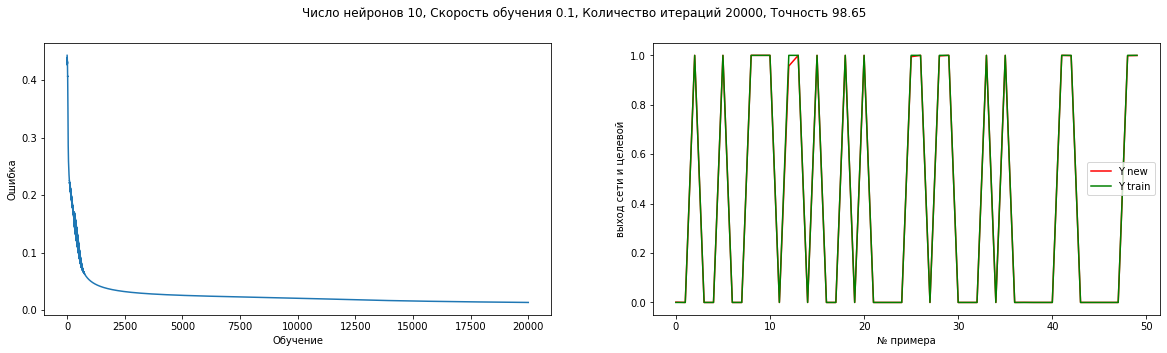

In [6]:
accuracy, error, layer, w0, w1 = two_layered_neu(iterations=20000)
plots(error, layer, y_train, accuracy, iterations=20000)

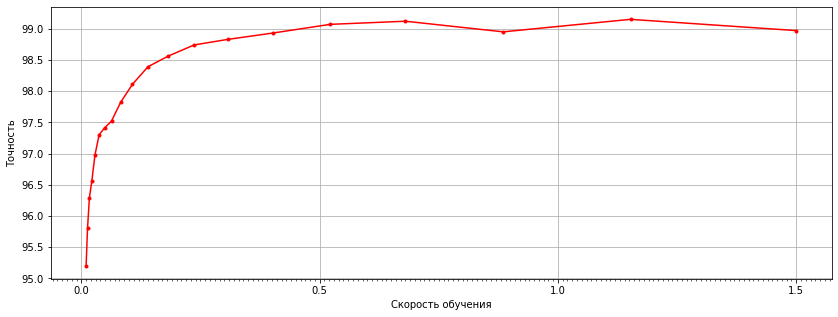

In [7]:
# Теперь попробуем варьировать скорость обучения

iter_values = []
range_values = np.geomspace(0.01, 1.5, 20)
for try_learning_rate in range_values:
    accuracy, error, last_layer, w0, w1 = two_layered_neu(n=try_learning_rate)
    iter_values.append(accuracy)
    
fig, ax = plt.subplots()
ax.plot(range_values, iter_values, 'r.-')

fig.set_figwidth(14)
fig.set_figheight(5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))

plt.xlabel('Скорость обучения')
plt.ylabel('Точность')
plt.grid()
plt.show()

#### График скорости обучения напоминает логарифмическую функцию практически до 1. После этого на графике точности резкий провал.

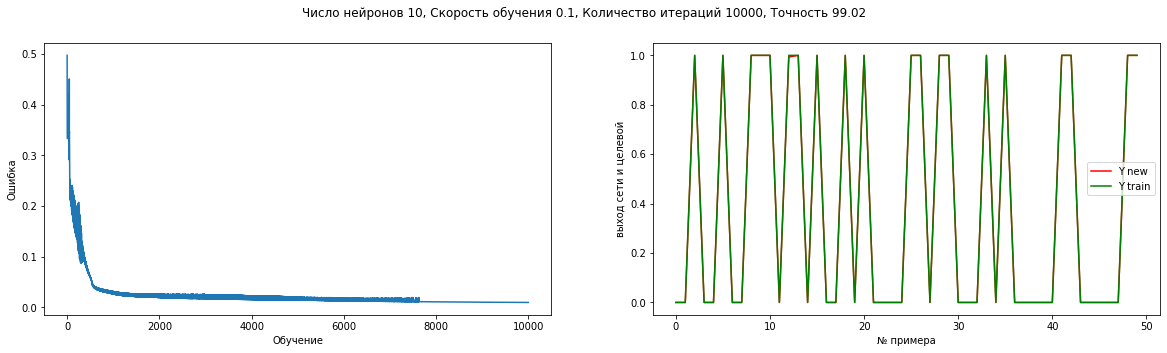

In [8]:
accuracy, error, layer, w0, w1 = two_layered_neu(n=0.5)
plots(error, layer, y_train, accuracy, n=0.1)

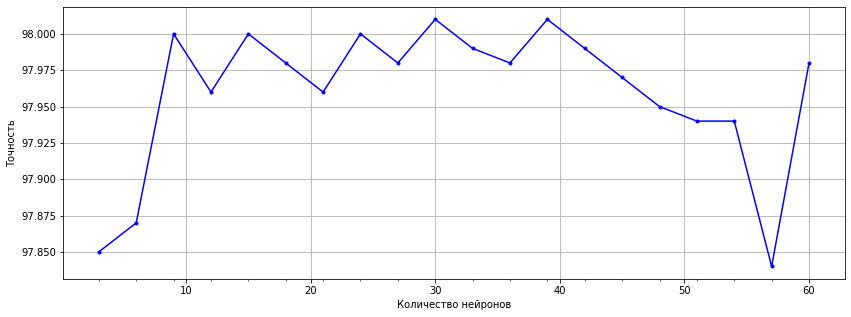

In [9]:
# Теперь займемся варьированием количества нейронов

iter_values = []
range_values = range(3, 60+1, 3)
for try_neurons in range_values:
    accuracy, error, last_layer, w0, w1 = two_layered_neu(neuron_numb=try_neurons)
    iter_values.append(accuracy)
    
fig, ax = plt.subplots()
ax.plot(range_values, iter_values, 'b.-')

fig.set_figwidth(14)
fig.set_figheight(5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(3))

plt.xlabel('Количество нейронов')
plt.ylabel('Точность')
plt.grid()
plt.show()

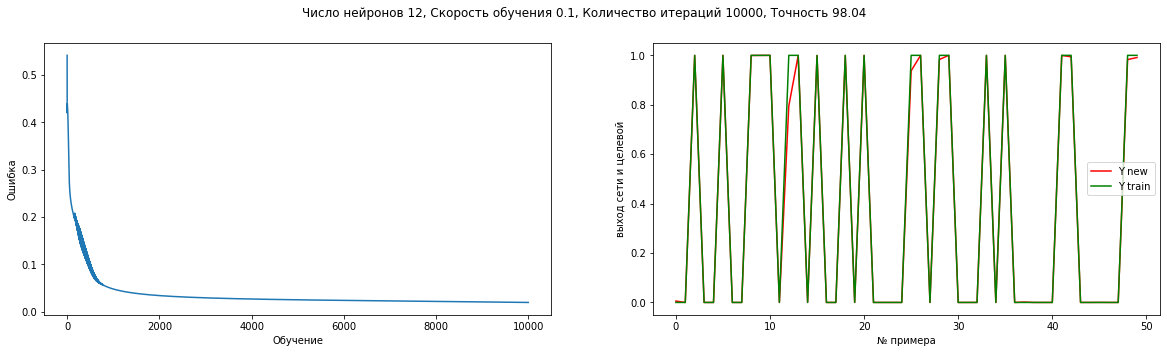

In [10]:
accuracy, error, layer, w0, w1 = two_layered_neu(neuron_numb=12)
plots(error, layer, y_train, accuracy, neuron_numb=12)

#### По графику видно, что точность сильно не зависит от количества нейронов на внутреннем слое.

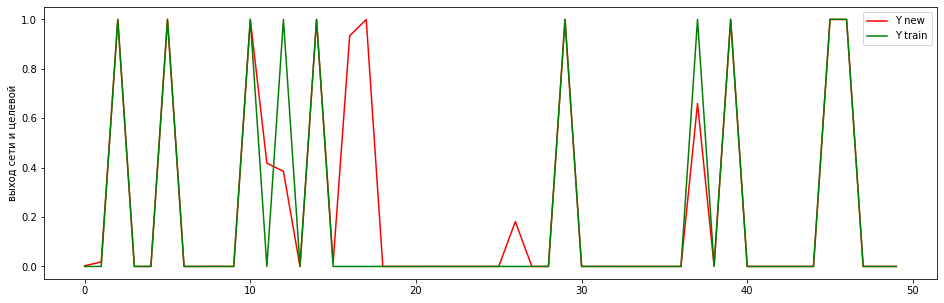

Аккуратность нейронной сети на тесте 94.97%


In [11]:
accuracy, error, layer, w0, w1 = two_layered_neu()

# прямое распространение(feed forward)
layer0_t = X_test
layer1_t = sigmoid(np.dot(layer0_t, w0))
layer2_t = sigmoid(np.dot(layer1_t, w1))
layer2_error_t = y_test - layer2_t

    
N = 50
plt.figure(figsize = (16,5))
plt.plot(layer2_t[:N,1], 'r',label = 'Y new')
plt.plot(y_test[:N,1],'g', label = 'Y train')
plt.ylabel('выход сети и целевой')
plt.legend( )
plt.show()

# метрика модели
error_t = np.mean(np.abs(layer2_error_t))
accuracy_t = (1 - error_t) * 100
print("Аккуратность нейронной сети на тесте " + str(round(accuracy_t,2)) + "%")

In [12]:
# Попробуем сделать два внутренних слоя. Остальные параметры возьмем те, которые дали наилучшие результаты на предыдущих испытаниях.

first_layer_neurons = 20
second_layer_neurons = 10

# присваевание случайных весов
w0 = 2*np.random.random((4, first_layer_neurons)) - 1 # для входного слоя   - 4 входа, 3 выхода
w1 = 2*np.random.random((first_layer_neurons, second_layer_neurons)) - 1 # для внутреннего слоя - 5 входов, 3 выхода
w2 = 2*np.random.random((second_layer_neurons, 3))

# массив для ошибок, чтобы потом построить график
errors = []

# процесс обучения
for i in range(20000):

    # прямое распространение(feed forward)
    layer0 = X_train
    layer1 = sigmoid(np.dot(layer0, w0))
    layer2 = sigmoid(np.dot(layer1, w1))
    layer3 = sigmoid(np.dot(layer2, w2))

    # обратное распространение(back propagation) с использованием градиентного спуска
    layer3_error = y_train - layer3 # производная функции потерь = производная квадратичных потерь 
    layer3_delta = layer3_error * sigmoid_deriv(layer3)

    layer2_error = layer3_delta.dot(w2.T)
    layer2_delta = layer2_error * sigmoid_deriv(layer2)
    
    layer1_error = layer2_delta.dot(w1.T)
    layer1_delta = layer1_error * sigmoid_deriv(layer1)
    
    # коррекция
    w2 += layer2.T.dot(layer3_delta) * 0.3
    w1 += layer1.T.dot(layer2_delta) * 0.3
    w0 += layer0.T.dot(layer1_delta) * 0.3
    
    # метрика модели
    error = np.mean(np.abs(layer2_error))
    errors.append(error)
    accuracy = (1 - error) * 100
    
accuracy

99.94148157390597

#### Даже учитывая, что мы взяли, не подбирая, произвольное количество внутренних нейронов, точность вышла почти 100%, что говорит о том, что два внутренних слоя намного лучше одного.